In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import minimize
import os

In [3]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [4]:
def lineal(x, a, b):
    linea = a*x + b
    return linea

def lloyd_taylor(t, ref, e0):
    # Poner t en centigrados
    t0 = 267
    # e0 = 63
    resp = ref * np.exp(-e0/(t + 273.16 -t0))
    return resp
def respiracion(t, ref, e0):
    # Poner t en Kelvin    
    tref = 283.16
    resp = ref * np.exp(e0*(1-tref/t)*(1/tref*8.31))
    return resp
def q10(t, ref, q10):
    # Poner t en centigrados
    tref = 283.16
    resp = ref * q10**((t+273.16-tref)/10)
    return resp

def beta(b0, k, vpd, vpd0):
    if vpd > vpd0:
        beta = b0 * np.exp(-k*(vpd-vpd0))
    else:
        beta = b0
    return beta
def gpp(alfa, beta, rg):
    gpp = (alfa*beta*rg) / (alfa*rg + beta)
    return gpp
def nee(resp, gpp):
    nee = resp + gpp
    return nee

In [5]:
def chequear_pesos(x, pesos):
    if pesos is None:
        pesos = np.ones(len(x))
    return pesos
def wlsq(x0, x, y, modelo, pesos = None):
    pesos = chequear_pesos(x, pesos)
    lsq = ((modelo(x, *x0) - y)/pesos)**2
    total = np.sum(lsq)
    return total
def mad(x0, x, y, modelo, pesos = None):
    mad = np.sqrt(abs((modelo(x, *x0) - y)/pesos))
    total = np.sum(mad)
    return total

In [6]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def regresion(modelo, x, y, pesos = None):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(modelo, x, y, sigma = pesos)
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo
def regr_libre(perdida, modelo, x, y, inicial, pesos = None):
    out = minimize(perdida, inicial,
                   args = (x, y, modelo, pesos),
                   bounds = ([0, 0], [10, 20])
                  )
    ajuste = out.x
    cov = np.diag(out.hess_inv)
    errores = np.sqrt(cov)
    predicciones = modelo(x, *ajuste)
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo
def regr_lsq(perdida, modelo, x, y, inicial, pesos = None):
    # La funcion perdida debe tener sqrt, pues least_squares la eleva al cuadrado
    # Ejemplo: mad = np.sqrt(2*abs(lsq(x0, X, Y, modelo, pesos))) es L1
    out = least_squares(perdida, inicial,
                        args = (x, y, modelo, pesos),
                        # verbose = 2
                        method = 'lm'
                       )
    ajuste = out.x
    J = out.jac
    cov = np.linalg.inv(J.T.dot(J))
    errores = np.sqrt(np.diagonal(cov))
    predicciones = modelo(x, *ajuste)
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo

In [7]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras):
    texto = str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
    return texto
def grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuad, nombres,
                   j = 3
                  ):
    etiqueta = ''
    iterador = list(range(len(nombres)))
    for i in iterador:
        valor = cifras_signif(ajuste[i], j)
        error = cifras_signif(errores[i], j)
        etiqueta = (etiqueta
                    + ' ' + nombres[i] + ' = ' + valor
                    + '; std ' + nombres[i] + ' = ' + error
                    + '\n')
    etiqueta = etiqueta + ' R^2 = ' + cifras_signif(r_cuad, j)
    plt.plot(x, y, 'bo', markersize = 2)
    plt.plot(x, predicciones, 'r-',
             label = etiqueta
             )
    plt.legend(fontsize = 20)
    return
def grafico_residuos(x, res):
    plt.plot(x, res, 'bo', markersize = 2)
    plt.axhline(0, color = 'black', linestyle = '--')
    return

In [8]:
def regresion_y_grafico(modelo, x, y, xlabel,
                        ylabel, nombres, pesos = None):
    predicciones, ajuste, errores, r_cuadrado, res = regresion(modelo,
                                                               x, y,
                                                               pesos)
    plt.subplot(221)
    grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuadrado, nombres
                  )
    metadata(xlabel, ylabel)
    plt.subplot(222)
    grafico_residuos(x, res)
    metadata(xlabel, ylabel)
    return ajuste, r_cuadrado, errores
def regr_y_graf_libre(modelo, x, y, xlabel,
                      ylabel, nombres, perdida,
                      inicial, pesos = None):
    predicciones, ajuste, errores, r_cuadrado, res = regr_libre(perdida,
                                                                modelo,
                                                                x, y,
                                                                inicial,
                                                                pesos
                                                                )
    plt.subplot(221)
    grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuadrado, nombres
                  )
    metadata(xlabel, ylabel)
    plt.subplot(222)
    grafico_residuos(x, res)
    metadata(xlabel, ylabel)
    return ajuste, r_cuadrado, errores
def identidad(metodo, ajuste, validacion_x, validacion_y, lab, nombres):
    iterador = list(validacion_x.index)
    pred = list(range(len(validacion_x)))
    for i in iterador:
        j = iterador.index(i)
        pred[j] = metodo(validacion_x[i], *ajuste)
    recta, ajuste, errores, r_cuadrado, res = regresion(lineal,
                                                        validacion_y,
                                                        pred
                                                       )
    plt.subplot(223)
    grafico_modelo(validacion_y, pred, recta,
                   ajuste, errores, r_cuadrado,
                   nombres
                  )
    metadata(lab + ' Obs', lab + ' Pred')
    extremos = [validacion_y.min(), validacion_y.max()]
    plt.plot(extremos, extremos, 'g--')
    return pred, r_cuadrado, ajuste, errores

In [9]:
def mbe(x, y):
    n = x.count()
    diff = y - x
    mbe = diff.sum() * (1/n)
    return mbe
def mae(x, y):
    n = x.count()
    diff = abs(y - x)
    mae = diff.sum() * (1/n)
    return mae
def mse(x, y):
    n = x.count()
    diff = (y - x)**2
    mse = diff.sum() * (1/n)
    return mse
def rmse(x, y):
    rmse = (mse(x, y))**(1/2)
    return rmse
def indice_acuerdo(x, y):
    diff = (y - x)**2
    long = (np.abs(x) + np.abs(y))**2
    d = 1 - diff.sum()/long.sum()
    return d
def tabla_metricas(nombres = []):
    cols = ['MBE','MAE', 'MSE', 'RMSE',
            'R2_reg', 'R2_val', 'Acuerdo',
            'a val', 'std a val', 'b val',
            'std b val', 'n_aj', 'n_val'
           ]
    cols = cols + nombres
    iterador = list(range(len(nombres)))
    for i in iterador:
        nombres[i] = 'std ' + nombres[i]
    cols = cols + nombres
    num = len(cols)
    datos = np.zeros((1, num))
    tabla = pd.DataFrame(data = datos, columns = cols)
    return tabla
def metricas(x, y, tabla, j = 3):
    mbe_f = cifras_signif(mbe(x, y), j)
    mae_f = cifras_signif(mae(x, y), j)
    mse_f = cifras_signif(mse(x, y), j)
    rmse_f = cifras_signif(rmse(x, y), j)
    indice_f = cifras_signif(indice_acuerdo(x, y), j)
    tabla['MBE'][0] = mbe_f
    tabla['MAE'][0] = mae_f
    tabla['MSE'][0] = mse_f
    tabla['RMSE'][0] = rmse_f
    tabla['Acuerdo'][0] = indice_f
    return tabla
def grafico_metricas(tabla, lab):
    ax1 = plt.subplot(224)
    ax1.bar(tabla.columns[:4],
            tabla[tabla.columns[:4]].iloc[0],
            color = 'red'
            )
    metadata('', lab)
    ax2 = ax1.twinx()
    metr = list(tabla[tabla.columns[4:7]].iloc[0].values)
    ceros = [0, 0, 0, 0]
    lista = ceros + metr
    ax2.bar(tabla.columns[:7],
            lista,
            color = 'blue',
           )
    ax2.set_ylim(0, 1)
    metadata('', '')
    return

In [10]:
def analisis(metodo, x, y, validacion_x, validacion_y,
             xlab, ylab, nombres, tabla, perdida, inicial,
             pesos = None
             ):
    grafico = plt.figure(figsize = (36, 18)).subplots(2, 2)
    ajuste, r_ajuste, std_ajuste = regr_y_graf_libre(metodo,
                                                     np.array(x),
                                                     np.array(y),
                                                     xlab, ylab,
                                                     nombres,
                                                     perdida,
                                                     inicial,
                                                     pesos
                                                     )
    pred, r_validac, recta, std_recta = identidad(metodo, ajuste,
                                                  validacion_x,
                                                  validacion_y,
                                                  ylab, ['a', 'b']
                                                  )
    tabla['R2_reg'][0] = r_ajuste
    tabla['R2_val'][0] = r_validac
    resultados = metricas(validacion_y, pred, tabla)
    grafico_metricas(resultados, ylab)
    resultados['n_aj'][0] = x.count() 
    resultados['n_val'][0] = validacion_x.count()
    iterador = list(range(len(nombres)))
    for i in iterador:
        resultados[nombres[i]][0] = ajuste[i]
        resultados['std ' + nombres[i]][0] = std_ajuste[i]
    resultados['a val'][0] = recta[0]
    resultados['std a val'][0] = std_recta[0]
    resultados['b val'][0] = recta[1]
    resultados['std b val'][0] = std_recta[1]
    return grafico, resultados

In [11]:
datos = pd.read_csv(
    'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    #'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [12]:
resumen(datos)

Forma:
 (14442, 37) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'TS1', 'TS2', 'TS3', 'TS4', 'U', 'DIR', 'PP', 'QG1',
       'QG2', 'WET', 'PAR', 'TSH1', 'HS1', 'GH1', 'TSH2', 'HS2', 'GH2', 'TSH3',
       'HS3', 'GH3', 'TSH4', 'HS4', 'GH4', '   r_err_co2[%]',
       '   noise_co2[%]'],
      dtype='object') 

 Tipos:
 Year               float64
DoY                float64
Hour               float64
NEE                float64
LE                 float64
H                  float64
Rg                 float64
Tair               float64
Tsoil              float64
rH                 float64
VPD                float64
Ustar              float64
TS1                float64
TS2                float64
TS3                float64
TS4                float64
U                  float64
DIR                float64
PP                 float64
QG1                float64
QG2                float64
WET                float64
PAR              

In [13]:
datos['Error porcent'] = datos['   r_err_co2[%]'] + datos['   noise_co2[%]']
datos['Error'] = abs(datos['Error porcent']/100 * datos['NEE'])

In [14]:
dias = np.array([0, 16, 46, 76,
                107, 137, 168, 199,
                229, 260, 290, 303
                ])
lista = list(range(1, len(dias)))
promedio = list(range(1, len(dias)))
for i in lista:
    desde = dias[i-1] * 48
    hasta = dias[i] * 48
    promedio[i-1] = datos['Tair'][desde:hasta].mean()
print(promedio)

[20.153313802083336, 17.015215277777788, 16.98765277777783, 10.506136724960305, 7.781109929078067, 8.458080736543934, 10.250757575757623, 13.119559027777756, 14.593571908602158, 17.034160839160883, 21.359814814814897]


In [15]:
datos['Tair'].mean()

13.521831034482787

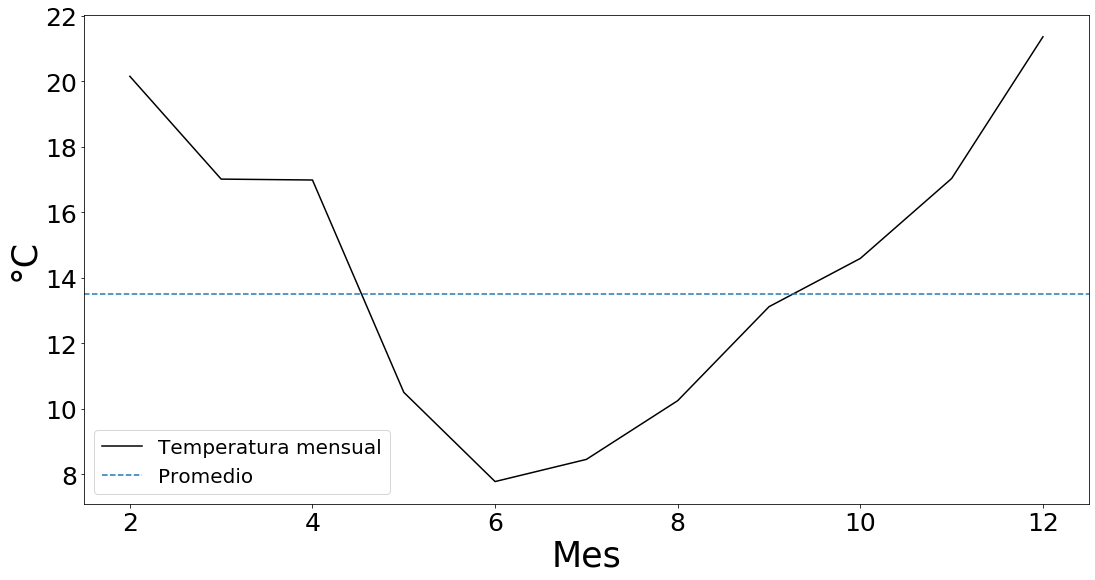

In [16]:
x = list(range(2, 13))
plt.figure(figsize = (18, 9))
plt.plot(x, promedio, color = 'black')
metadata('Mes', '°C')
plt.axhline(datos['Tair'].mean(), ls = '--')
plt.legend(['Temperatura mensual', 'Promedio'], fontsize= 20)

In [17]:
datos_validos = datos[(datos['Rg'] < 5)
                      & (datos['Ustar'] > 0.14167)
                      & pd.notna(datos['Tair'])
                      & (datos['NEE'] >= 0)
                      & (datos['Error porcent'] < 40)
                     ]
datos_validos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,TSH3,HS3,GH3,TSH4,HS4,GH4,r_err_co2[%],noise_co2[%],Error porcent,Error
count,2085.0,2085.000000,2085.000000,2085.000000,2033.000000,2084.000000,2.085000e+03,2085.000000,2085.000000,2085.000000,...,1987.000000,1987.000000,1987.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000
mean,2018.0,248.618225,11.157794,1.680845,7.763134,-33.357975,1.597530e-01,11.381854,11.603709,80.172856,...,12.935521,0.536427,0.209232,12.575935,0.406046,0.288700,12.565085,0.995927,13.561013,0.234882
std,0.0,63.346767,9.142561,1.382466,18.243090,16.793468,6.118013e-01,4.464177,3.526699,9.404374,...,3.510447,0.030963,0.026383,3.083171,0.035048,0.041625,4.786447,1.017122,5.124504,0.258526
min,2018.0,91.000000,0.000000,0.000450,-111.854263,-138.818542,1.808498e-12,-1.005000,4.187500,29.065000,...,5.830000,0.447000,0.148000,7.330000,0.219500,0.111000,5.653092,0.135974,6.510600,0.000038
1%,2018.0,94.000000,0.000000,0.035542,-20.737532,-80.425055,5.000000e-03,1.909000,5.052700,54.618000,...,6.700000,0.458000,0.149000,7.400000,0.325860,0.167000,7.502335,0.302624,8.363725,0.004131
10%,2018.0,164.000000,1.000000,0.328640,-9.660343,-55.587951,1.500000e-02,5.779000,7.398500,66.894000,...,8.583000,0.469000,0.174000,8.900000,0.354000,0.238000,8.757647,0.467327,9.578532,0.040263
25%,2018.0,208.000000,3.000000,0.713300,-3.912702,-43.540737,2.000000e-02,8.605000,8.560000,74.985000,...,9.795000,0.540500,0.188750,9.800000,0.390000,0.273000,9.695578,0.572093,10.490035,0.087871
50%,2018.0,256.000000,6.500000,1.330000,4.434532,-31.186451,2.500000e-02,11.040000,11.335000,82.000000,...,12.640000,0.547500,0.208500,12.300000,0.409500,0.297500,11.080297,0.729704,11.922530,0.165070
75%,2018.0,300.000000,21.000000,2.248250,14.860677,-21.454665,3.000000e-02,14.025000,14.272500,87.450000,...,15.800000,0.553000,0.227000,15.200000,0.429000,0.315000,13.528194,1.006305,14.671408,0.287785
90%,2018.0,325.000000,22.500000,3.505300,29.212522,-14.311057,5.500000e-02,17.588000,16.719000,90.450000,...,17.723000,0.559500,0.247700,17.178000,0.448500,0.337000,18.405852,1.604096,19.636048,0.479118


<ErrorbarContainer object of 3 artists>

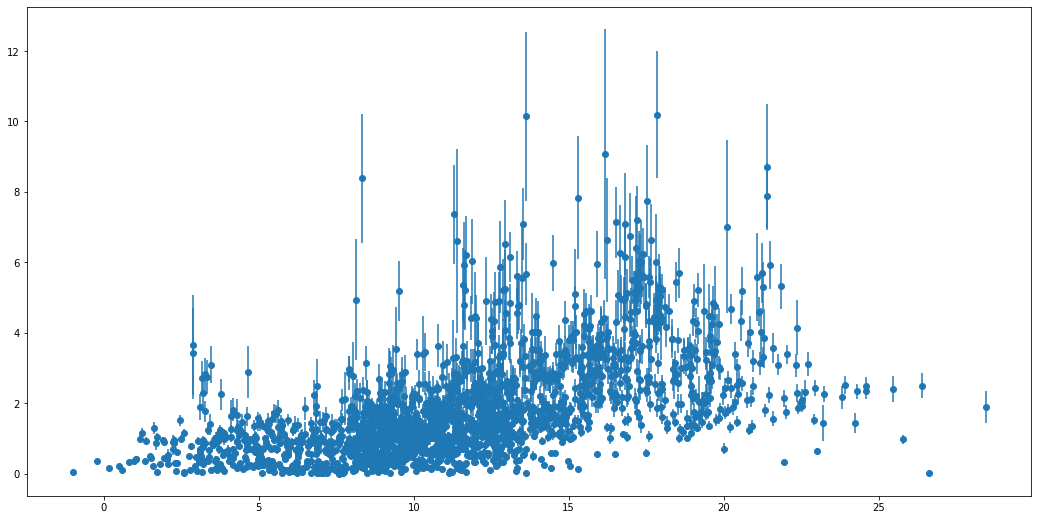

In [18]:
plt.figure(figsize=(18,9))
plt.errorbar(datos_validos['Tair'], datos_validos['NEE'], datos_validos['Error'], fmt='o')

In [22]:
def todo(predictora, modelo, perdida):
    inicial = [2, 3]
    #camino = 'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Modelos\\'
    camino = 'C:\\Users\\nahue\\Desktop\\Tesis_2\\Modelos\\'
    guardado = camino + modelo[0].__name__+ '\\' + perdida.__name__ + '\\' + predictora + '\\'
    if not os.path.exists(guardado):
        os.makedirs(guardado)
    muestra_tot = datos_validos.sample(frac = 4/5, random_state = 1).sort_values(predictora)
    validacion_tot = datos_validos.drop(muestra_tot.index)
    # muestra_tot['Error'] = np.ones(len(muestra_tot))
    tair_mod_1_tot, para_analisis = analisis(modelo[0],
                                             muestra_tot[predictora],
                                             muestra_tot['NEE'],
                                             validacion_tot[predictora],
                                             validacion_tot['NEE'],
                                             '°C', 'micromol/(m^2 s)',
                                             modelo[1:],
                                             tabla_metricas(modelo[1:]),
                                             perdida,
                                             inicial,
                                             muestra_tot['Error']
                                            )
    titulo = 'Desde 0 Hasta 360'
    para_analisis['Desde'] = muestra_tot['DoY'].min()
    para_analisis['Hasta'] = muestra_tot['DoY'].max()
    plt.savefig(guardado + titulo + '.png')
    dias = np.arange(60, 420, 60)
    iterador = list(range(1, len(dias)))
    for i in iterador:
        desde = dias[i-1]
        hasta = dias[i]
        muestra_vent = muestra_tot[(muestra_tot['DoY'] > desde)
                               & (muestra_tot['DoY'] < hasta)
                               ]
        validacion_vent = validacion_tot[(validacion_tot['DoY'] > desde)
                                         & (validacion_tot['DoY'] < hasta)
                                         ]
        cant_mu = muestra_vent['NEE'].notnull().sum()
        cant_va = validacion_vent['NEE'].notnull().sum()
        if cant_mu > 10 and cant_va > 5:
            titulo = 'Desde ' + str(desde) + ' Hasta ' + str(hasta)
            tair_mod_1_ven, error_vent = analisis(modelo[0],
                                                  muestra_vent[predictora],
                                                  muestra_vent['NEE'],
                                                  validacion_vent[predictora],
                                                  validacion_vent['NEE'],
                                                  '°C', 'micromol/(m^2 s)',
                                                  modelo[1:],
                                                  tabla_metricas(modelo[1:]),
                                                  perdida,
                                                  inicial,
                                                  muestra_vent['Error']
                                                 )
            plt.savefig(guardado + titulo +'.png')
            plt.close()
            error_vent['Desde'] = muestra_vent['DoY'].min()
            error_vent['Hasta'] = muestra_vent['DoY'].max()
            para_analisis = para_analisis.append(error_vent, ignore_index = True)
    dias = np.arange(90, 355, 5)
    iterador = list(range(3, len(dias)))
    for i in iterador:
        desde = dias[i-3]
        hasta = dias[i]
        muestra_vent = muestra_tot[(muestra_tot['DoY'] > desde)
                               & (muestra_tot['DoY'] < hasta)
                               ]
        validacion_vent = validacion_tot[(validacion_tot['DoY'] > desde)
                                         & (validacion_tot['DoY'] < hasta)
                                         ]
        cant_mu = muestra_vent['NEE'].notnull().sum()
        cant_va = validacion_vent['NEE'].notnull().sum()
        if cant_mu > 10 and cant_va > 5:
            titulo = 'Desde ' + str(desde) + ' Hasta ' + str(hasta)
            tair_mod_1_ven, error_vent = analisis(modelo[0],
                                                  muestra_vent[predictora],
                                                  muestra_vent['NEE'],
                                                  validacion_vent[predictora],
                                                  validacion_vent['NEE'],
                                                  '°C', 'micromol/(m^2 s)',
                                                  modelo[1:],
                                                  tabla_metricas(modelo[1:]),
                                                  perdida,
                                                  inicial,
                                                  muestra_vent['Error']
                                                 )
            plt.savefig(guardado + titulo + '.png')
            plt.close()
            error_vent['Desde'] = muestra_vent['DoY'].min()
            error_vent['Hasta'] = muestra_vent['DoY'].max()
            para_analisis = para_analisis.append(error_vent, ignore_index = True)
    para_analisis.to_csv(guardado + 'Resultados.csv',
                         sep = '\t',
                         na_rep = -9999,
                         index = False,
                         encoding = 'ascii'
                         )
    print(perdida.__name__ + ' ' + predictora + ' Listo!')
    return

In [24]:
predictora = ['Tair', 'Tsoil', 'TS1', 'TS2']
lloyd = [lloyd_taylor, 'Ref', 'E0']
Q10 = [q10, 'Ref', 'Q10']
perdida = [wlsq, mad]

ValueError: Input must be 1- or 2-d.

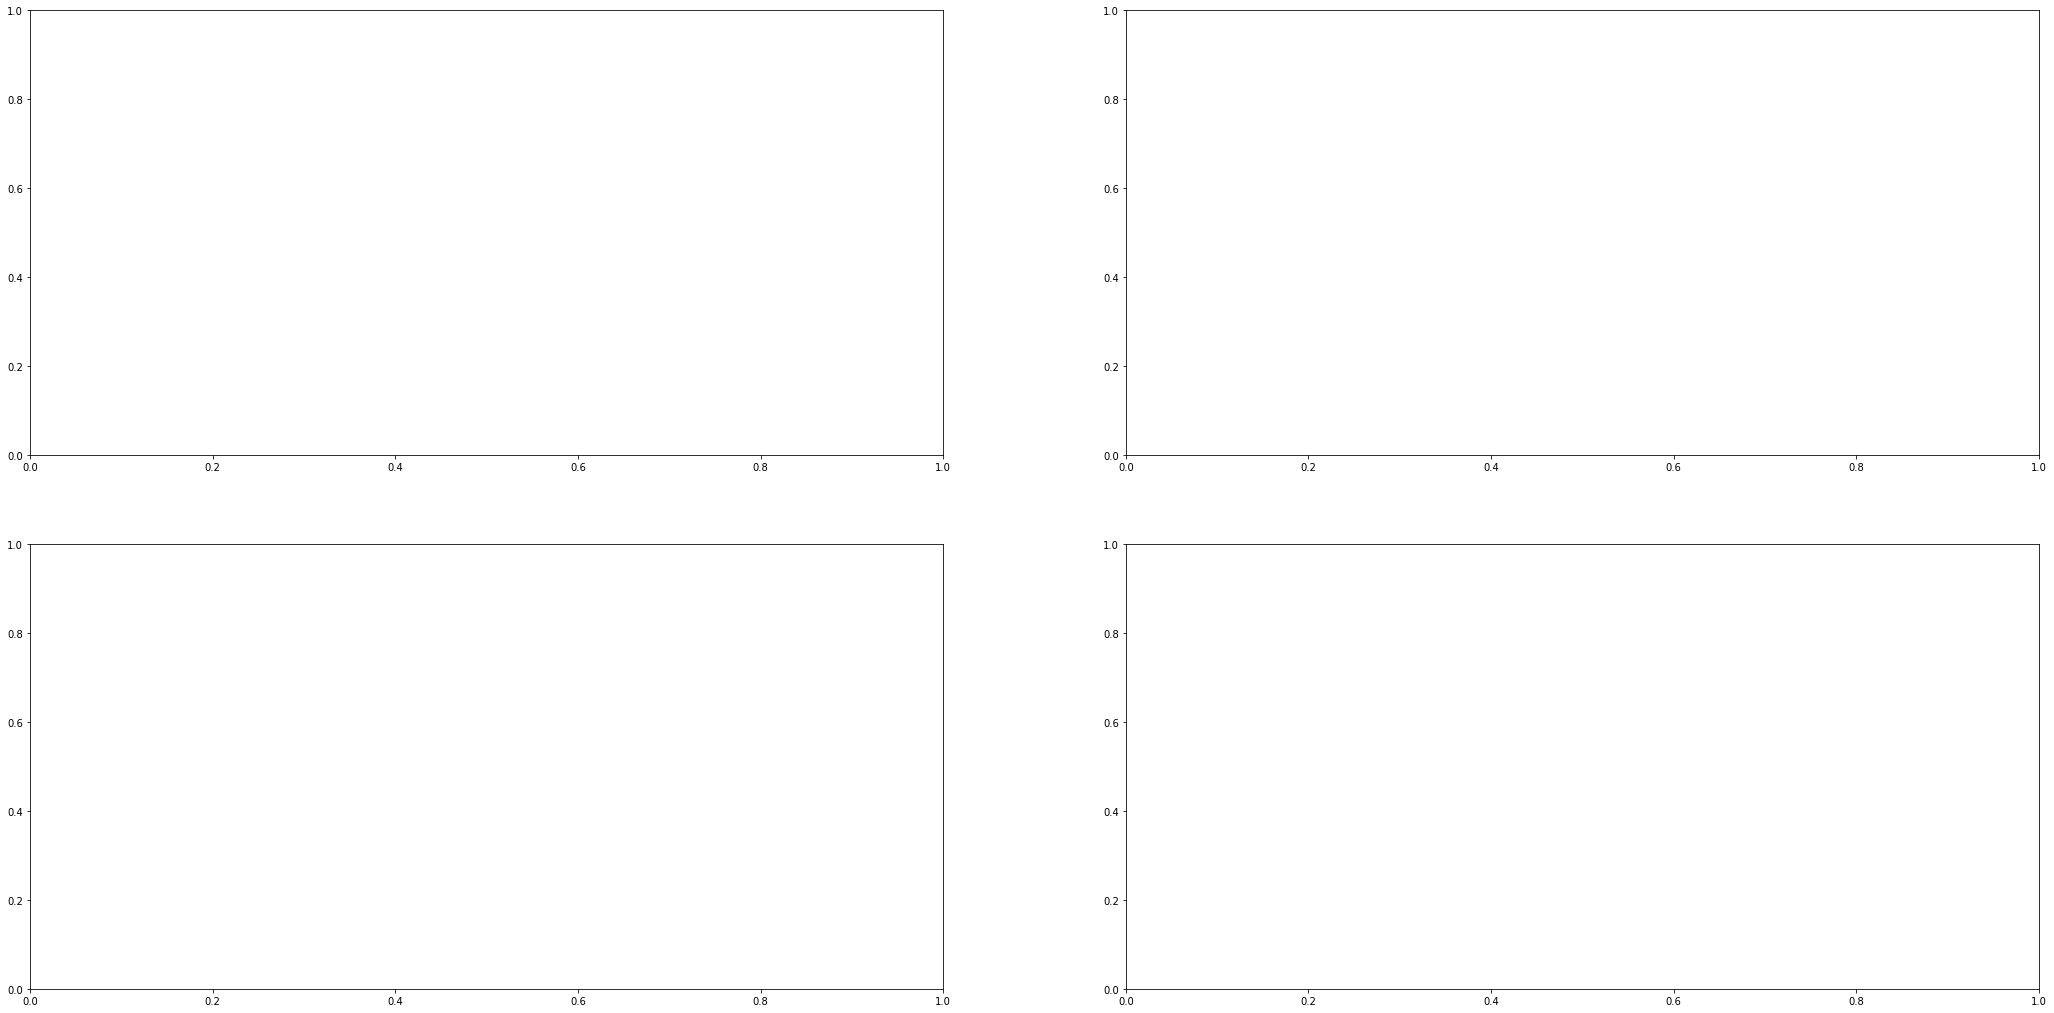

In [30]:
todo(predictora[0], Q10, perdida[0])